# Neural networks to predict the CO2 emissions of a car

## Libraries installation

In [44]:
%pip install numpy
%pip install pandas
%pip install scikit-learn
%pip install matplotlib
%pip install seaborn

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


## Dataset description

|           Attribute            |                                       Description                                        |
|:------------------------------:|:----------------------------------------------------------------------------------------:|
|       1 (`engine_size`)        |                                  Engine size in liters.                                  |
|        2 (`cylinders`)         |                            Number of cylinders in the engine.                            |
|  3 (`fuel_consumption_city`)   | Fuel consumption of the vehicle in urban area ($\frac{ \text{ L } }{ 100 } \text{ km }$) |
| 4 (`fuel_consumption_highway`) |  Fuel consumption of the vehicle in highway ($\frac{ \text{ L } }{ 100 } \text{ km }$)   |
|      5 (`CO2_emissions`)       |         CO2 emissions of the vehicle, where $0$ means "Low" and $1$ means "High"         |

In [45]:
import sklearn
import warnings
from sklearn.exceptions import ConvergenceWarning


warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [46]:
import pandas as pd


source = "data.csv"
data = pd.read_csv(source, sep=",")

data.columns = [
	"engine_size",
	"cylinders",
	"fuel_consumption_city",
	"fuel_consumption_highway",
	"CO2_emissions",
]

In [47]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1067 entries, 0 to 1066
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   engine_size               1067 non-null   float64
 1   cylinders                 1067 non-null   int64  
 2   fuel_consumption_city     1067 non-null   float64
 3   fuel_consumption_highway  1067 non-null   float64
 4   CO2_emissions             1067 non-null   int64  
dtypes: float64(3), int64(2)
memory usage: 41.8 KB


## Quantitative variables

### `int64`

In [48]:
data.select_dtypes(include=["int64"]).describe()

,cylinders,CO2_emissions
count,1067.000000,1067.000000
mean,5.794752,0.461106
std,1.797447,0.498719
min,3.000000,0.000000
25%,4.000000,0.000000
50%,6.000000,0.000000
75%,8.000000,1.000000
max,12.000000,1.000000


### `float64`

In [49]:
data.select_dtypes(include=["float64"]).describe()

,engine_size,fuel_consumption_city,fuel_consumption_highway
count,1067.000000,1067.000000,1067.000000
mean,3.346298,13.296532,9.474602
std,1.415895,4.101253,2.794510
min,1.000000,4.600000,4.900000
25%,2.000000,10.250000,7.500000
50%,3.400000,12.600000,8.800000
75%,4.300000,15.550000,10.850000
max,8.400000,30.200000,20.500000


## Data separation

In [50]:
from sklearn.model_selection import train_test_split


total = len(data)
train = int(total * 0.8)
test = total - train
print(total, train, test)

train_data, test_data = sklearn.model_selection.train_test_split(data, train_size=train, test_size=test)

1067 853 214


In [51]:
print(train_data.shape)
train_data.info()

(853, 5)
<class 'pandas.core.frame.DataFrame'>
Index: 853 entries, 221 to 79
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   engine_size               853 non-null    float64
 1   cylinders                 853 non-null    int64  
 2   fuel_consumption_city     853 non-null    float64
 3   fuel_consumption_highway  853 non-null    float64
 4   CO2_emissions             853 non-null    int64  
dtypes: float64(3), int64(2)
memory usage: 40.0 KB


## Pipelining

### Numeric attributes (pipeline)

In [52]:
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler


numeric_attributes = [
	"engine_size",
	"cylinders",
	"fuel_consumption_city",
	"fuel_consumption_highway"
]

numeric_pipeline = Pipeline([
						("imputer", SimpleImputer(strategy="median")),
						("scaler", StandardScaler())
					])

### Full pipeline

In [53]:
from sklearn.compose import ColumnTransformer


full_pipeline = ColumnTransformer([
					("num", numeric_pipeline, numeric_attributes)
				])

In [54]:
x_train = full_pipeline.fit_transform(train_data)
y_train = train_data["CO2_emissions"]

x_test = full_pipeline.transform(test_data)
y_test = test_data["CO2_emissions"]

## Models

In [55]:
models = [
	("relu", "adam", (10, 10, 10)),
	("tanh", "sgd", (5, 5)),
	("logistic", "lbfgs", (7, 3)),
	("identity", "adam", (15, 5, 2)),
	("relu", "lbfgs", (3,))
]

In [56]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.neural_network import MLPClassifier


models_results = []
confusion_matrices = []

for activation, solver, hidden_layer in models:
	model = MLPClassifier(activation=activation, solver=solver, hidden_layer_sizes=hidden_layer, random_state=123)
	model.fit(x_train, y_train)

	y_pred = model.predict(x_test)
	accurancy = accuracy_score(y_test, y_pred)

	models_results.append((activation, solver, hidden_layer, accurancy))
	confusion_matrices.append((activation, solver, hidden_layer, confusion_matrix(y_test, y_pred)))

### Results (models)

In [57]:
results_df = pd.DataFrame(models_results, columns=["Activation", "Solver", "Hidden Layers", "Accuracy"])
print(results_df)

  Activation Solver Hidden Layers  Accuracy
0       relu   adam  (10, 10, 10)  0.953271
1       tanh    sgd        (5, 5)  0.957944
2   logistic  lbfgs        (7, 3)  0.957944
3   identity   adam    (15, 5, 2)  0.943925
4       relu  lbfgs          (3,)  0.953271


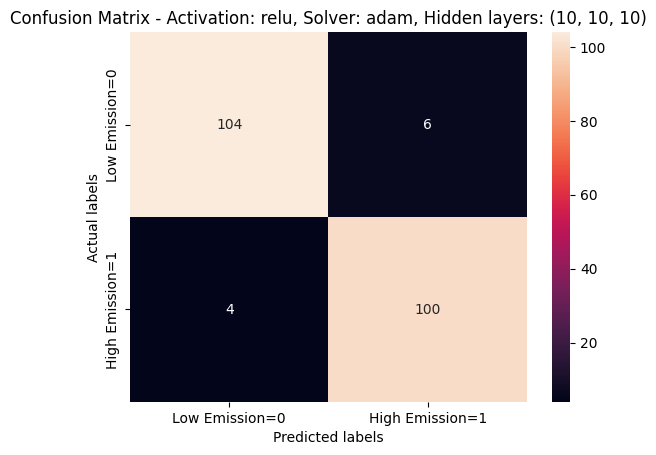

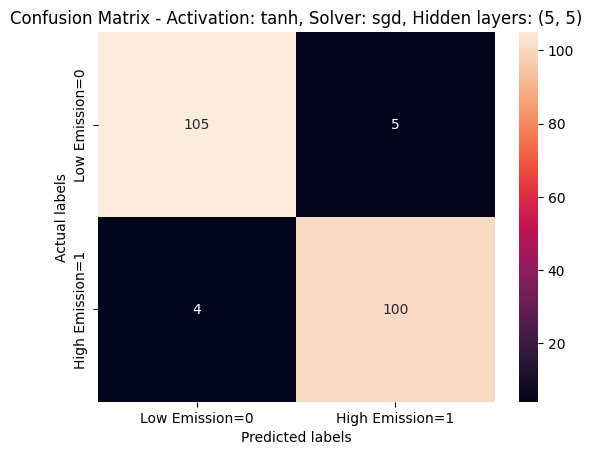

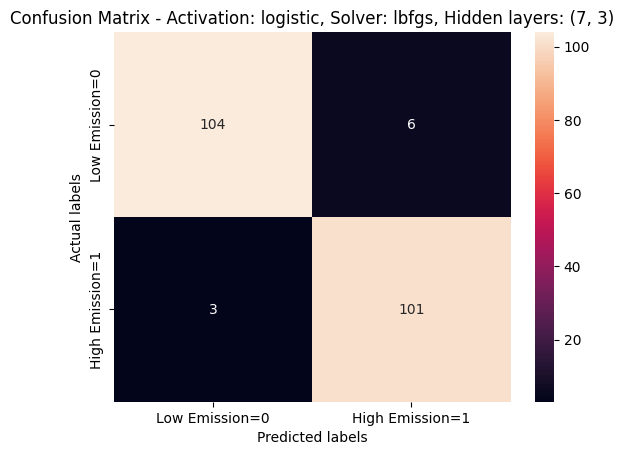

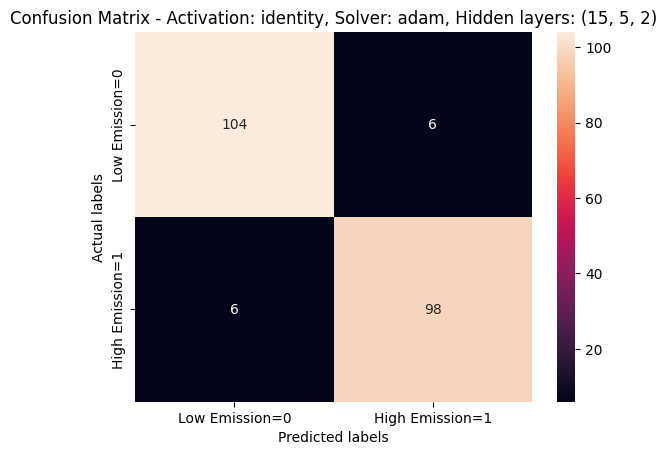

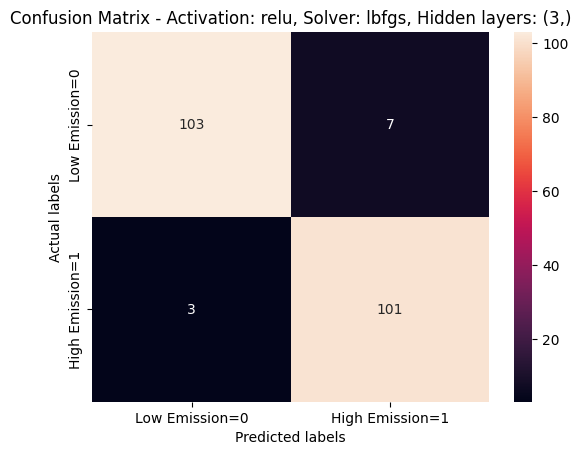

In [58]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns



for (activation, solver, hidden_layer, conf_matrix) in confusion_matrices:
	ax = plt.subplot()
	sns.heatmap(conf_matrix, annot=True, ax=ax, fmt="d")

	ax.set_xlabel("Predicted labels")
	ax.set_ylabel("Actual labels")
	ax.set_title(f"Confusion Matrix - Activation: {activation}, Solver: {solver}, Hidden layers: {hidden_layer}")
	ax.xaxis.set_ticklabels(["Low Emission=0", "High Emission=1"])
	ax.yaxis.set_ticklabels(["Low Emission=0", "High Emission=1"])
	plt.show()

In [59]:
best_model = results_df.loc[results_df["Accuracy"].idxmax()]

print(f'Best Model - Activation: {best_model["Activation"]}\tSolver: {best_model["Solver"]}\tHidden Layers: {best_model["Hidden Layers"]}\tAccuracy: {best_model["Accuracy"]}')

Best Model - Activation: tanh	Solver: sgd	Hidden Layers: (5, 5)	Accuracy: 0.9579439252336449


### Modifications to the best model

In [60]:
alpha_values = [0.001, 0.01, 0.1]
alpha_results = []

for alpha_value in alpha_values:
	model = MLPClassifier(activation=best_model["Activation"], solver=best_model["Solver"],
							hidden_layer_sizes=best_model["Hidden Layers"], alpha=alpha_value, random_state=123)
	model.fit(x_train, y_train)

	y_pred = model.predict(x_test)
	accuracy = accuracy_score(y_test, y_pred)
	alpha_results.append(accuracy)

In [61]:
default_model_accuracy = best_model["Accuracy"]

print(f"Default best model\tAccuracy: {default_model_accuracy}\tAlpha: 0.0001\n")

Default best model	Accuracy: 0.9579439252336449	Alpha: 0.0001



#### Results (modifications to the best model)

In [62]:
for alpha_index, alpha_result in enumerate(alpha_results):
	percentage_improvement = (alpha_result - default_model_accuracy) / default_model_accuracy * 100
	print(f"Alpha: {alpha_values[alpha_index]}\tImprovement: {percentage_improvement}%\n")

Alpha: 0.001	Improvement: 0.0%

Alpha: 0.01	Improvement: 0.0%

Alpha: 0.1	Improvement: 0.0%

